# Project 3

### The Data Science Process

1. Problem Statement
2. Data Collection
3. Data Cleaning 
4. Preprocessing & EDA
5. Modelling & Evaluation
6. Conclusion and Suggestions


# Problem Statement

- Given a random posts, assign accordingly to the correct twitter account based on similar occuring words.
- What are the most repeated words in each tweet.
- What is the average length of words for each tweet.

# Data Collection

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

In [2]:
# import previously scraped data from twitter
df = pd.read_csv('./dataset/df_tweets.csv')

In [3]:
df = df.drop(columns='Unnamed: 0')

In [4]:
df.head()

,username,accident_id,created_at,text,len,source
0,muftimenk,1452791747633979396,2021-10-26 00:18:38+00:00,Not everyone will be happy for you. Stop shari...,286,Twitter for Android
1,muftimenk,1452616037527076868,2021-10-25 12:40:26+00:00,Making a choice is not easy at times. Always s...,267,Twitter for Android
2,muftimenk,1452392455421181953,2021-10-24 21:52:00+00:00,Well done #Pakistan \nGreat Win #PakistanCrick...,60,Twitter for Android
3,muftimenk,1452388751813062657,2021-10-24 21:37:17+00:00,Your good deeds won’t guarantee you Paradise. ...,282,Twitter for Android
4,muftimenk,1452259714318876676,2021-10-24 13:04:32+00:00,Don’t fall for Satan’s plot. He does not want ...,279,Twitter for Android


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   username     1799 non-null   object
 1   accident_id  1799 non-null   int64 
 2   created_at   1799 non-null   object
 3   text         1799 non-null   object
 4   len          1799 non-null   int64 
 5   source       1799 non-null   object
dtypes: int64(2), object(4)
memory usage: 84.5+ KB


# Data Cleaning

In [6]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

In [7]:
# select only the relevant columns
df = df[['username', 'text', 'len']]

In [8]:
# check both subreddits are included
df['username'].unique()

array(['muftimenk', 'mizi_wahid'], dtype=object)

In [9]:
# map the subreddit to a binary 
df['username'] = df['username'].map({'muftimenk': 0, 'mizi_wahid': 1})
df.head()

,username,text,len
0,0,Not everyone will be happy for you. Stop shari...,286
1,0,Making a choice is not easy at times. Always s...,267
2,0,Well done #Pakistan \nGreat Win #PakistanCrick...,60
3,0,Your good deeds won’t guarantee you Paradise. ...,282
4,0,Don’t fall for Satan’s plot. He does not want ...,279


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  1799 non-null   int64 
 1   text      1799 non-null   object
 2   len       1799 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 42.3+ KB


In [11]:
# check for null values
df.isna().sum()

username    0
text        0
len         0
dtype: int64

In [12]:
STOPWORDS = set(stopwords.words('english'))
MIN_WORDS = 4
MAX_WORDS = 200

PATTERN_S = re.compile(r"'s")  # matches `'s` from text
PATTERN_NOT = re.compile("n't")  # matches `n't` from text
PATTERN_NT = re.compile("nt")  # matches `n't` from text
PATTERN_WILL = re.compile("'ll")  # matches `'ll` from text
PATTERN_ARE = re.compile("re")  # matches `re` from text
PATTERN_RN = re.compile(r"\r\\n") #matches `\r` and `\n`
PATTERN_URL = re.compile(r"http\S+") # remove url
PATTERN_HASH = re.compile(r"#") # remove hashtags
PATTERN_RT = re.compile("rt") # remove hashtags
PATTERN_AT = re.compile(r"@([a-zA-Z0-9_]{1,50})") # remove account name from retweeted tweet
PATTERN_PUNC = re.compile(r"[^\w\s]") # matches all non 0-9 A-z whitespace
PATTERN_AMP = re.compile(r"amp") # matches all non 0-9 A-z whitespace 


def clean_text(text):
    """
    Series of cleaning. String to lower case, remove non words characters and numbers (punctuation, curly brackets etc).
        text (str): input text
    return (str): modified initial text
    """
    text = text.lower()  # lowercase text
    text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", text)
    
    # replace the matched string with ' '
    #text = re.sub(PATTERN_S, ' ', text)
    text = re.sub(PATTERN_NOT, ' not', text)
    text = re.sub(PATTERN_NT, ' not', text)
    #text = re.sub(PATTERN_WILL, 'will', text)
    text = re.sub(PATTERN_ARE, ' are', text)
    #text = re.sub(PATTERN_RN, ' ', text)
    #text = re.sub(PATTERN_URL, ' ', text)
    #text = re.sub(PATTERN_HASH, ' ', text)
    #text = re.sub(PATTERN_RT, ' ', text)
    #text = re.sub(PATTERN_AT, ' ', text)
    #text = re.sub(PATTERN_PUNC, ' ', text)
    text = re.sub(PATTERN_AMP, ' ', text)
    
    return text

def tok_lem(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS, lemmatize=True):
    """
    Lemmatize, tokenize, crop and remove stop words.
    Args:
      sentence (str)
      min_words (int)
      max_words (int)
      stopwords (set of string)
      lemmatize (boolean)
    returns:
      list of string
    """
    if lemmatize:
        stemmer = WordNetLemmatizer()
        tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    else:
        tokens = [w for w in word_tokenize(sentence)]
    token = [w for w in tokens if (len(w) > min_words and len(w) < max_words
                                                        and w not in stopwords)]
    
    return tokens    

def tokenizer(sentence, min_words=MIN_WORDS, max_words=MAX_WORDS):
    """
    Lemmatize, tokenize.
    Args:
      sentence (str)
      min_words (int)
      max_words (int)
    returns:
      list of string
    """
    stemmer = WordNetLemmatizer()
    tokens = [stemmer.lemmatize(w) for w in word_tokenize(sentence)]
    
    return tokens  

def clean_sentences(df):
    """
    Remove irrelavant characters (in new column clean_sentence).
    Lemmatize, tokenize words into list of words (in new column tok_lem_sentence).
    Args: 
      df (dataframe)
     returns:
      df
    """
    print('Cleaning sentences...')
    df['clean_sentence'] = df['text'].apply(clean_text)
    df['token_sentence'] = df['clean_sentence'].apply(
        lambda x: tokenizer(x, min_words=MIN_WORDS, max_words=MAX_WORDS))
    df['tok_lem_sentence'] = df['clean_sentence'].apply(
        lambda x: tok_lem(x, min_words=MIN_WORDS, max_words=MAX_WORDS, stopwords=STOPWORDS))
    
    print('Cleaning Done !')
    print('----------\n')
    print(df.info())
    return df
    
df = clean_sentences(df)

Cleaning sentences...
Cleaning Done !
----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   username          1799 non-null   int64 
 1   text              1799 non-null   object
 2   len               1799 non-null   int64 
 3   clean_sentence    1799 non-null   object
 4   token_sentence    1799 non-null   object
 5   tok_lem_sentence  1799 non-null   object
dtypes: int64(2), object(4)
memory usage: 84.5+ KB
None


In [13]:
df.head(10)

,username,text,len,clean_sentence,token_sentence,tok_lem_sentence
0,0,Not everyone will be happy for you. Stop shari...,286,not everyone will be happy for you stop sharin...,"[not, everyone, will, be, happy, for, you, sto...","[not, everyone, will, be, happy, for, you, sto..."
1,0,Making a choice is not easy at times. Always s...,267,making a choice is not easy at times always se...,"[making, a, choice, is, not, easy, at, time, a...","[making, a, choice, is, not, easy, at, time, a..."
2,0,Well done #Pakistan \nGreat Win #PakistanCrick...,60,well done pakistan g areat win pakistancricket...,"[well, done, pakistan, g, areat, win, pakistan...","[well, done, pakistan, g, areat, win, pakistan..."
3,0,Your good deeds won’t guarantee you Paradise. ...,282,your good deeds wo not guara notee you paradis...,"[your, good, deed, wo, not, guara, notee, you,...","[your, good, deed, wo, not, guara, notee, you,..."
4,0,Don’t fall for Satan’s plot. He does not want ...,279,do not fall for satans plot he does not wa not...,"[do, not, fall, for, satan, plot, he, doe, not...","[do, not, fall, for, satan, plot, he, doe, not..."
5,0,We tend to think the grass is always greener o...,276,we tend to think the grass is always g areener...,"[we, tend, to, think, the, grass, is, always, ...","[we, tend, to, think, the, grass, is, always, ..."
6,0,We are in a sad state today. We let society di...,278,we a are in a sad state today we let society d...,"[we, a, are, in, a, sad, state, today, we, let...","[we, a, are, in, a, sad, state, today, we, let..."
7,0,Knowing what not to say is equally important. ...,292,knowing what not to say is equally importa not...,"[knowing, what, not, to, say, is, equally, imp...","[knowing, what, not, to, say, is, equally, imp..."
8,0,Don’t let them make you believe that loving yo...,265,do not let them make you believe that loving y...,"[do, not, let, them, make, you, believe, that,...","[do, not, let, them, make, you, believe, that,..."
9,0,Almighty. We ask You to purify our hearts. Hel...,270,almighty we ask you to purify our hearts help ...,"[almighty, we, ask, you, to, purify, our, hear...","[almighty, we, ask, you, to, purify, our, hear..."


In [14]:
df['cs_len'] = df['clean_sentence'].str.len()
df['word counts'] = df['token_sentence'].str.len()
df['word count after tok_lem'] = df['tok_lem_sentence'].str.len()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   username                  1799 non-null   int64 
 1   text                      1799 non-null   object
 2   len                       1799 non-null   int64 
 3   clean_sentence            1799 non-null   object
 4   token_sentence            1799 non-null   object
 5   tok_lem_sentence          1799 non-null   object
 6   cs_len                    1799 non-null   int64 
 7   word counts               1799 non-null   int64 
 8   word count after tok_lem  1799 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 126.6+ KB


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   username                  1799 non-null   int64 
 1   text                      1799 non-null   object
 2   len                       1799 non-null   int64 
 3   clean_sentence            1799 non-null   object
 4   token_sentence            1799 non-null   object
 5   tok_lem_sentence          1799 non-null   object
 6   cs_len                    1799 non-null   int64 
 7   word counts               1799 non-null   int64 
 8   word count after tok_lem  1799 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 126.6+ KB


In [16]:
#drop useless rows

def drop_rows(df):
    #drop rows with empty list
    df.drop(df.loc[df['clean_sentence']== ' '].index, inplace=True)
    #drop rows with less or equal to five word
    df.drop(df.loc[df['word counts'] <= 5].index, inplace=True)
    return df

In [17]:
drop_rows(df)

,username,text,len,clean_sentence,token_sentence,tok_lem_sentence,cs_len,word counts,word count after tok_lem
0,0,Not everyone will be happy for you. Stop shari...,286,not everyone will be happy for you stop sharin...,"[not, everyone, will, be, happy, for, you, sto...","[not, everyone, will, be, happy, for, you, sto...",284,55,55
1,0,Making a choice is not easy at times. Always s...,267,making a choice is not easy at times always se...,"[making, a, choice, is, not, easy, at, time, a...","[making, a, choice, is, not, easy, at, time, a...",261,50,50
2,0,Well done #Pakistan \nGreat Win #PakistanCrick...,60,well done pakistan g areat win pakistancricket...,"[well, done, pakistan, g, areat, win, pakistan...","[well, done, pakistan, g, areat, win, pakistan...",56,7,7
3,0,Your good deeds won’t guarantee you Paradise. ...,282,your good deeds wo not guara notee you paradis...,"[your, good, deed, wo, not, guara, notee, you,...","[your, good, deed, wo, not, guara, notee, you,...",282,53,53
4,0,Don’t fall for Satan’s plot. He does not want ...,279,do not fall for satans plot he does not wa not...,"[do, not, fall, for, satan, plot, he, doe, not...","[do, not, fall, for, satan, plot, he, doe, not...",284,63,63
...,...,...,...,...,...,...,...,...,...
1794,1,RT @nafrinaM: Who does God love?\n\n📓 You are ...,88,who does god love you a are loved by wahid,"[who, doe, god, love, you, a, are, loved, by, ...","[who, doe, god, love, you, a, are, loved, by, ...",45,10,10
1795,1,"RT @snflwrlover_: ✨ - The Art of Letting God, ...",81,the art of letting god wahid,"[the, art, of, letting, god, wahid]","[the, art, of, letting, god, wahid]",33,6,6
1796,1,New Episode brought to you by Houze of Telekun...,71,new episode brought to you by houze of telekung,"[new, episode, brought, to, you, by, houze, of...","[new, episode, brought, to, you, by, houze, of...",48,9,9
1797,1,"Peace be upon you,\n\nYou’re going to be just ...",52,peace be upon youyou are going to be just fine,"[peace, be, upon, youyou, are, going, to, be, ...","[peace, be, upon, youyou, are, going, to, be, ...",46,10,10


# Pre-Processing and EDA

In [18]:
# seperate the two subreddits for individual visualisations
muftimenk = df[df['username'] == 0]
print(muftimenk.shape)
mizi_wahid = df[df['username'] == 1]
print(mizi_wahid.shape)

(896, 9)
(657, 9)


In [19]:
# Average length for muftimenk's posts
print('The average length per tweet:', muftimenk['cs_len'].mean())
print('The longest tweet length:', muftimenk['cs_len'].max())
print('The average word count per tweet:', muftimenk['word counts'].mean())
print('The maximum word count per tweet:', muftimenk['word counts'].max())

The average length per tweet: 269.2533482142857
The longest tweet length: 293
The average word count per tweet: 52.1328125
The maximum word count per tweet: 64


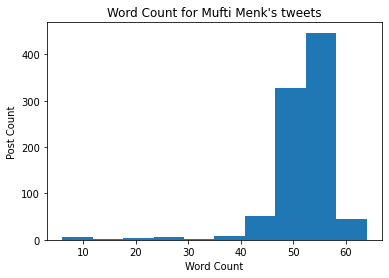

In [20]:
plt.hist(muftimenk['word counts'])
plt.title("Word Count for Mufti Menk's tweets")
plt.xlabel('Word Count')
plt.ylabel('Post Count');

In [21]:
# Average length for serious posts
print('The average length per tweet:', mizi_wahid['cs_len'].mean())
print('The longest tweet length:', mizi_wahid['cs_len'].max())
print('The average word count per tweet:', mizi_wahid['word counts'].mean())
print('The maximum word count per tweet:', mizi_wahid['word counts'].max())

The average length per tweet: 196.03500761035008
The longest tweet length: 290
The average word count per tweet: 36.981735159817354
The maximum word count per tweet: 63


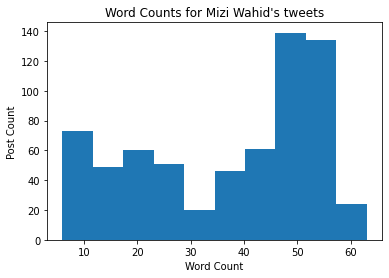

In [22]:
plt.hist(mizi_wahid['word counts'])
plt.title("Word Counts for Mizi Wahid's tweets")
plt.xlabel('Word Count')
plt.ylabel('Post Count');

In [64]:
# imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, 
    precision_score, recall_score, f1_score
                                )
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

In [24]:
X = df['clean_sentence']
y = df['username']

In [25]:
X.shape

(1553,)

In [26]:
# Check for imbalanced data 
y.value_counts(normalize = True)

0    0.576948
1    0.423052
Name: username, dtype: float64

In [27]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

In [28]:
cvec = CountVectorizer(stop_words = STOPWORDS, max_df = 0.5, min_df=0.1)

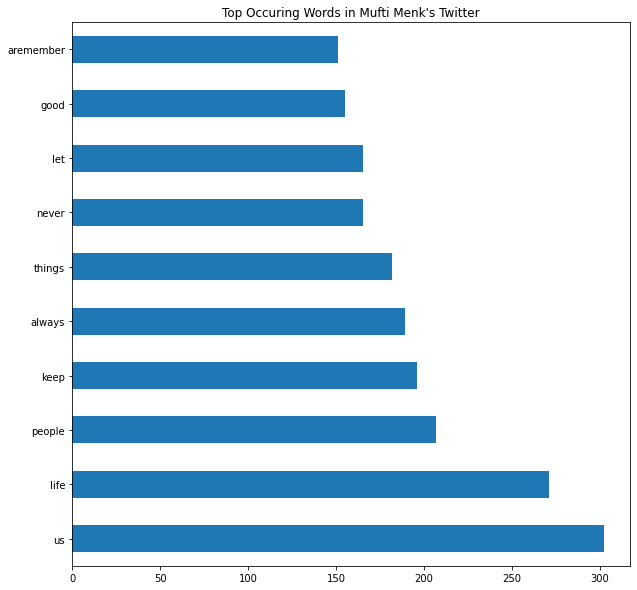

In [29]:
# convert text data to dataframe
text_mm = pd.DataFrame(cvec.fit_transform(muftimenk['clean_sentence']).todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
text_mm.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.yticks(size=10)
plt.title("Top Occuring Words in Mufti Menk's Twitter");

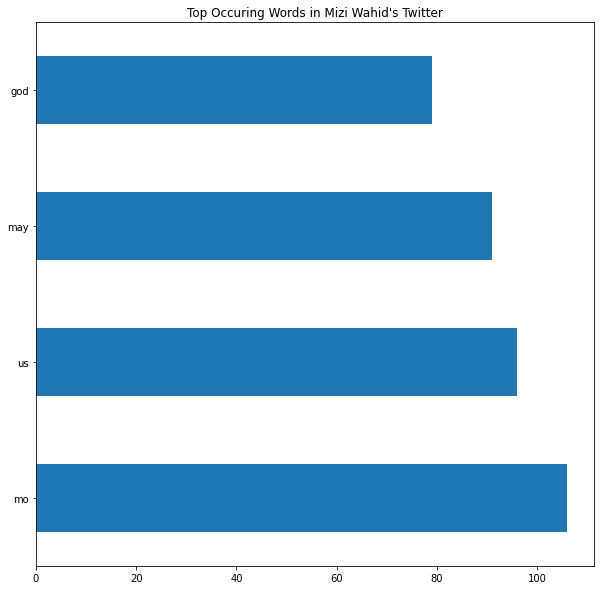

In [30]:
# convert text data to dataframe
text_mw = pd.DataFrame(cvec.fit_transform(mizi_wahid['clean_sentence']).todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
text_mw.sum().sort_values(ascending=False).plot(kind='barh')
plt.yticks(size=10)
plt.title("Top Occuring Words in Mizi Wahid's Twitter");

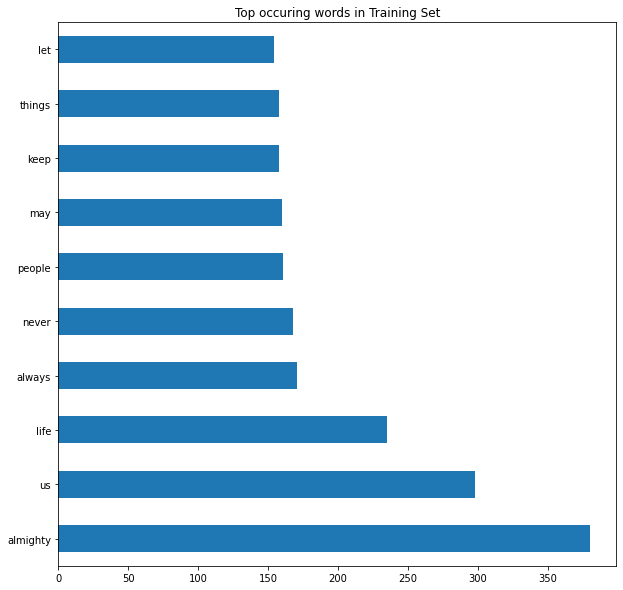

In [31]:
# convert training data to dataframe
X_train_df = pd.DataFrame(cvec.fit_transform(X_train).todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.yticks(size=10)
plt.title('Top occuring words in Training Set');

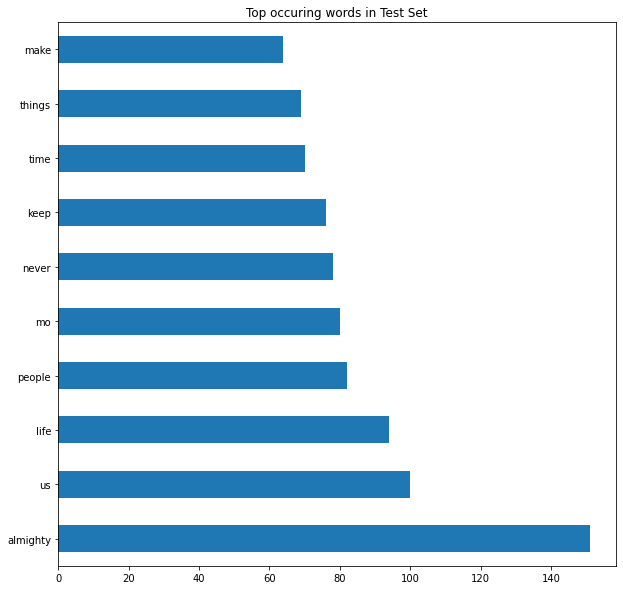

In [32]:
# convert test data to dataframe
X_test_df = pd.DataFrame(cvec.fit_transform(X_test).todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
plt.figure(figsize=(10,10))
X_test_df.sum().sort_values(ascending=False).head(10).plot(kind='barh')
plt.yticks(size=10)
plt.title('Top occuring words in Test Set');

# Modelling

In [33]:
# 1st Model
pipe_rf = Pipeline([
    ('cvec', CountVectorizer(stop_words=STOPWORDS)),
    ('rf', RandomForestClassifier(random_state=42))
])

In [34]:
rf_params = {
    'cvec__max_features': [170, 180, 190, 200],    
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df': [0.05, 0.1],
    'cvec__max_df': [.75, .8],
    'rf__max_depth': [1, 2]
}

In [35]:
gs_rf = GridSearchCV(pipe_rf,
                  param_grid=rf_params, 
                  cv=5)

In [36]:
# Fit GridSearch to training data.
rf_fit = gs_rf.fit(X_train, y_train)

In [37]:
# What's the best score and the best parameters?
print(gs_rf.best_score_)
print(gs_rf.best_params_)

0.831606984314886
{'cvec__max_df': 0.75, 'cvec__max_features': 170, 'cvec__min_df': 0.1, 'cvec__ngram_range': (1, 1), 'rf__max_depth': 2}


In [38]:
# Get predictions
pred_rf = gs_rf.predict(X_train)
preds_rf = gs_rf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_rf).ravel()

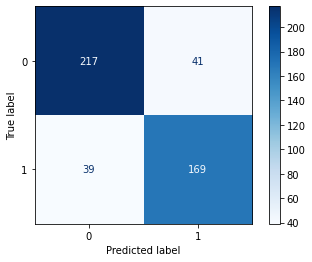

In [39]:
# View confusion matrix

plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues', values_format='d');

In [40]:
precision = precision_score(y_train, pred_rf, average='binary') #TruePositives / (TruePositives + FalsePositives)
print('Precision: %.3f' % precision)
recall = recall_score(y_train, pred_rf, average='binary') #TruePositives / (TruePositives + FalseNegatives)
print('Recall: %.3f' % recall)
score = f1_score(y_train, pred_rf, average='binary') #(2 * Precision * Recall) / (Precision + Recall)
print('F1-Score: %.3f' % score)
#Precision: Appropriate when minimizing false positives is the focus.
#Recall: Appropriate when minimizing false negatives is the focus.

Precision: 0.801
Recall: 0.806
F1-Score: 0.804


In [41]:
# Calculate Accuracy and check overfitting
print(accuracy_score(y_train, pred_rf))
print(accuracy_score(y_test, preds_rf))

0.8371665133394665
0.8283261802575107


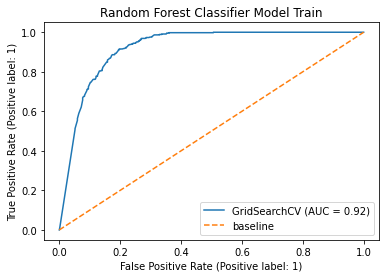

In [42]:
# plot roc for rf
plot_roc_curve(gs_rf, X_train, y_train)
plt.title('Random Forest Classifier Model Train')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

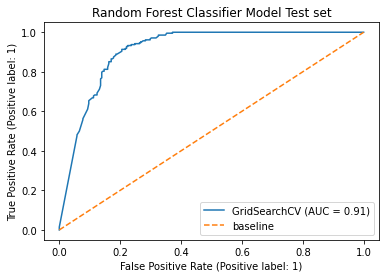

In [43]:
plot_roc_curve(gs_rf, X_test, y_test)
plt.title('Random Forest Classifier Model Test set')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [44]:
# 2nd Model
pipe_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words=STOPWORDS)),
    ('nb', MultinomialNB())
])

In [45]:
nb_params = {
    'cvec__max_features': [170, 180, 190, 200],   
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df': [.05, .1],
    'cvec__max_df': [.75, .8],
    'nb__alpha': [.1, .2, .3, .4]
}

In [46]:
gs_nb = GridSearchCV(pipe_nb,
                  param_grid=nb_params, 
                  cv=5) 

In [47]:
# Fit GridSearch to training data.
gs_nb.fit(X_train, y_train)

# What's the best score and the best parameters?
print(gs_nb.best_score_)
print(gs_nb.best_params_)

0.7322665201031582
{'cvec__max_df': 0.75, 'cvec__max_features': 170, 'cvec__min_df': 0.05, 'cvec__ngram_range': (1, 1), 'nb__alpha': 0.3}


In [48]:
# Get predictions
pred_nb = gs_nb.predict(X_train)
preds_nb = gs_nb.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_nb).ravel()

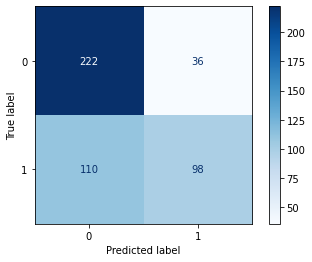

In [49]:
# View confusion matrix

plot_confusion_matrix(gs_nb, X_test, y_test, cmap='Blues', values_format='d');

In [50]:
precision = precision_score(y_train, pred_nb, average='binary') #TruePositives / (TruePositives + FalsePositives)
print('Precision: %.3f' % precision)
recall = recall_score(y_train, pred_nb, average='binary') #TruePositives / (TruePositives + FalseNegatives)
print('Recall: %.3f' % recall)
score = f1_score(y_train, pred_nb, average='binary') #(2 * Precision * Recall) / (Precision + Recall)
print('F1-Score: %.3f' % score)
#Precision: Appropriate when minimizing false positives is the focus.
#Recall: Appropriate when minimizing false negatives is the focus.

Precision: 0.780
Recall: 0.584
F1-Score: 0.668


In [51]:
# Calculate Accuracy and check for overfitting
print(accuracy_score(y_train, pred_nb))
print(accuracy_score(y_test, preds_nb))

0.7598896044158233
0.6866952789699571


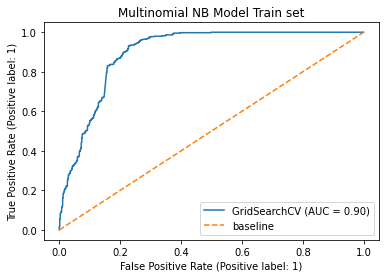

In [52]:
plot_roc_curve(gs_nb, X_train, y_train)
plt.title('Multinomial NB Model Train set')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

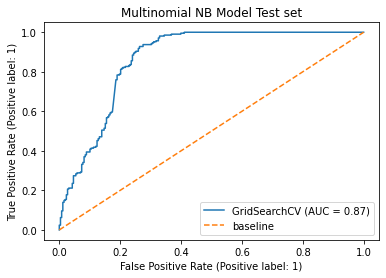

In [53]:
plot_roc_curve(gs_nb, X_test, y_test)
plt.title('Multinomial NB Model Test set')
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [57]:
# instantiating a count vectorizer for NLP
cvec = CountVectorizer(max_features=5_000, stop_words=STOPWORDS, ngram_range=(1,2))
# instantiating a TF-DIF vectorizer for NLP
tvec = TfidfVectorizer(max_features=5_000, stop_words=STOPWORDS, ngram_range=(1,2))

In [58]:

# fitting and transforming the training data to the count vectorizer
X_train_cv = cvec.fit_transform(X_train)
# transforming the test data to the count vectorizer
X_test_cv = cvec.transform(X_test)
# fitting and transforming the training data to the TF-DIF vectorizer
X_train_tv = tvec.fit_transform(X_train)
# transforming the test data to the count vectorizer
X_test_tv = tvec.transform(X_test)

In [59]:
# storing the vectorized data in a dataframe for easy viewing and visualizations
X_train_df = pd.DataFrame(X_train_cv.toarray(), columns=cvec.get_feature_names())
# viewing the data
X_train_df.head()

,10,100,1dayill,1st,20,2021,2nd,830,830 pm,930,...,youve done,youve got,youve living,youve lost,youve made,youve messed,youve never,youve wronged,youyou,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
# instantiating a logistic regression model
# from testing different options, the best result came from ridge regularization with an alpha of 5
lr = LogisticRegression(C=.2)
# fitting the TF-DIF vectorized training data to the model
lr.fit(X_train_tv, y_train)
# evaluating the model on the training data
print(f'Training Score: {cross_val_score(lr, X_train_tv, y_train, cv=5).mean()}')
# evaluating the model on the testing data
print(f'Test Score: {cross_val_score(lr, X_test_tv, y_test, cv=5).mean()}')

Training Score: 0.6448864837441339
Test Score: 0.6008693662777396


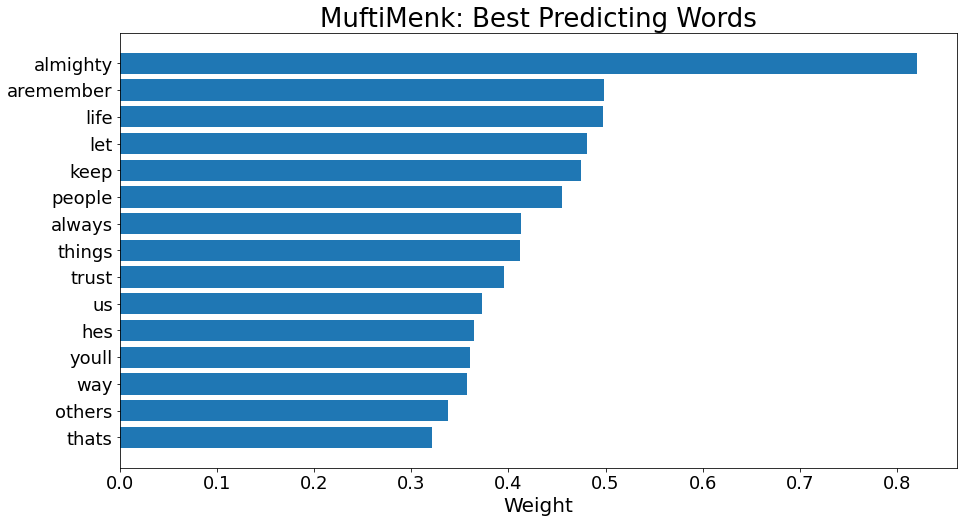

In [69]:
# creating a table of the bottom 15 coefficients and the words they belong to
table = log_coefs.sort_values(1).head(15)
# creating a figure in matplotlib and setting the size of the figure
plt.figure(figsize=(15,8))
# plotting a horizontal bar chart on the figure
# 1 - the coefficients to make the most relevent words the largest bar
plt.barh(table[0], (1 - table[1]))
# the line of code below was taken from stackoverflow.com
# flips the y axis so that the largest bars are on top
plt.ylim(plt.ylim()[::-1])
# setting the font of the yticks
plt.yticks(fontsize=18)
# labeling and formatting the x axis
plt.xlabel('Weight', fontsize=20)
# setting the font of the x ticks
plt.xticks(fontsize=18)
# setting and formatting the title
plt.title('MuftiMenk: Best Predicting Words', fontsize=26);

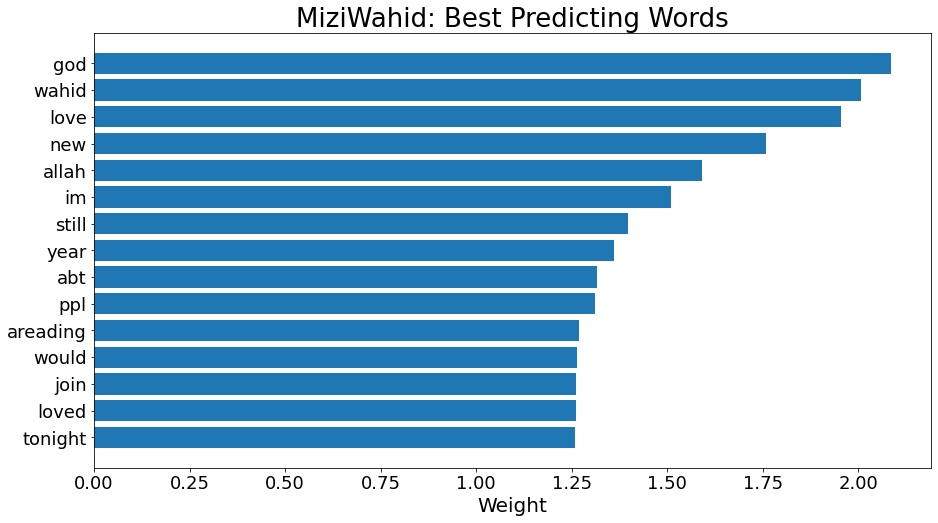

In [68]:
# creating a list of all words being analyzed with their corresponding coefficients from logistic regression
log_coefs = pd.DataFrame(list(zip(X_train_df, np.exp(lr.coef_[0]))))
# creating a table of the top 15 coefficients and the words they belong to
table = log_coefs.sort_values(1, ascending=False).head(15)
# creating a figure in matplotlib and setting the size of the figure
plt.figure(figsize=(15,8))
# plotting a horizontal bar chart on the figure
plt.barh(table[0], table[1])
# labeling and formatting the y axis
plt.xlabel('Weight', fontsize=20)
# setting the font for the xticks
plt.xticks(fontsize=18)
# the line of code below was taken from stackoverflow.com
# flips the y axis so that the largest bars are on top
plt.ylim(plt.ylim()[::-1])
# setting the font of the yticks
plt.yticks(fontsize=18)
# setting and formatting the title
plt.title('MiziWahid: Best Predicting Words', fontsize=26);

# Conclusion and Suggestions

### Summary:

|Item               | Mufti Menk | Mizi Wahid |
|-------------------|------------|------------|
|Average length/tweet| 269.25    | 196.03     |
|Longest tweet length| 293       | 290        |
|Average word count/tweet| 52.13 | 36.98      |
|Maximum word count/tweet| 64    | 63         |
|Top 5 occuring words | us, life, people, keep, always | mo, us, may, god |
| Top 5 best word predictors | Almighty, aremember, life, let, keep | god, wahid, love, new, Allah |

- Random Forest AUC train score = 0.92, test score = 0.91 with an F1_score = 0.80 
- Multinomial Naive Bayes AUC train score = 0.90, test score = 0.87 with an F1_score = 0.67 
- In conclusion: Random Forest Classifier performed better than MultinomialNB.


#### Suggestions to improve:

1. Additional words can be added into the list of stopwords, for example the words that has high frequency in both twitters.
2. Further improve on lemmatizing and tokenizing
3. Experiment with other types of algorithms and ensemble methods such as Boosting, Bagging etc.